In [24]:
import pandas as pd
import re
import seaborn as sns
import numpy as np
import math
import time
import matplotlib.pyplot as plt
%matplotlib inline

#LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()

In [ ]:
HDB_Full_Constructed = pd.read_csv("DataProject/flats-constructed-by-housing-and-development-board-annual.csv")
HDB_Full_Constructed.head(5)

In [ ]:
HDB_Full_Number_Sold_Rent = pd.read_csv("DataProject/number-of-sold-and-rented-residential-units.csv")
HDB_Full_Number_Sold_Rent.head(5)

In [3]:
HDB_Resale_1990_1999 = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-approval-date-1990-1999.csv")
HDB_Resale_2000Feb_2012 = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-approval-date-2000-feb-2012.csv")
HDB_Resale_2012Mar_2014Dec = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-registration-date-from-mar-2012-to-dec-2014.csv")
HDB_Resale_2015_2018Dec = pd.read_csv("DataProject/Resale/resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv")

In [ ]:
Full_Resale_HDB_List =  [HDB_Resale_1990_1999, HDB_Resale_2000Feb_2012,HDB_Resale_2012Mar_2014Dec,HDB_Resale_2015_2018Dec]
Full_Resale_HDB = pd.concat(Full_Resale_HDB_List)
Full_Resale_HDB.head(5)

In [ ]:
print(Full_Resale_HDB.info())
print(Full_Resale_HDB.shape)
#Full_Resale_HDB['remaining_lease'].isna().count()

Full_Resale_HDB['remaining_lease'] = Full_Resale_HDB['remaining_lease'].fillna(999)

In [ ]:
print(Full_Resale_HDB.info())
print(Full_Resale_HDB.shape)
Full_Resale_HDB.head(5)

In [ ]:
#Droplist Column 
droplist_train = ['block', 'lease_commence_date', 'remaining_lease', 'storey_range', 'street_name']
Full_Resale_HDB = Full_Resale_HDB.drop(droplist_train, axis = 1)


In [ ]:
Full_Resale_HDB.head(5)

In [ ]:
Full_Resale_HDB = pd.get_dummies(Full_Resale_HDB, columns=['town'])
Full_Resale_HDB = pd.get_dummies(Full_Resale_HDB, columns=['flat_model'])
for dataset in Full_Resale_HDB:
    dataset['Sex'] = le.fit_transform(dataset['flat_type'])



In [ ]:
Full_Resale_HDB['month'] = Full_Resale_HDB['month']
print(Full_Resale_HDB['index'])

In [ ]:
Full_Resale_HDB.head(5)

In [6]:
HDB_Resale_2015_2018Dec['month'] = HDB_Resale_2015_2018Dec['month'].str.slice(stop=4)
HDB_Resale_2015_2018Dec.head(5)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2015,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,07 TO 09,60.0,Improved,1986,70,255000.0
1,2015,ANG MO KIO,3 ROOM,541,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1981,65,275000.0
2,2015,ANG MO KIO,3 ROOM,163,ANG MO KIO AVE 4,01 TO 03,69.0,New Generation,1980,64,285000.0
3,2015,ANG MO KIO,3 ROOM,446,ANG MO KIO AVE 10,01 TO 03,68.0,New Generation,1979,63,290000.0
4,2015,ANG MO KIO,3 ROOM,557,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,64,290000.0


In [7]:
droplist_train = ['block', 'lease_commence_date', 'remaining_lease', 'storey_range', 'street_name','floor_area_sqm','flat_model']
HDB_Resale_2015_2018Dec = HDB_Resale_2015_2018Dec.drop(droplist_train, axis = 1)
HDB_Resale_2015_2018Dec['month'] = HDB_Resale_2015_2018Dec['month'].astype(int)

In [8]:
HDB_Resale_2015_2018Dec.tail(5)

,month,town,flat_type,resale_price
79095,2018,YISHUN,5 ROOM,470000.0
79096,2018,YISHUN,5 ROOM,500000.0
79097,2018,YISHUN,5 ROOM,500000.0
79098,2018,YISHUN,EXECUTIVE,708000.0
79099,2018,YISHUN,EXECUTIVE,560000.0


In [9]:
#HDB_Resale_2015_2018Dec = pd.get_dummies(HDB_Resale_2015_2018Dec, columns=['town'])
#HDB_Resale_2015_2018Dec = pd.get_dummies(HDB_Resale_2015_2018Dec, columns=['flat_model'])
# HDB_Resale_2015_2018Dec['town'] = le.fit_transform(HDB_Resale_2015_2018Dec['town'])
HDB_Resale_2015_2018Dec = pd.get_dummies(HDB_Resale_2015_2018Dec, columns=['town'])

In [10]:
HDB_Resale_2015_2018Dec['flat_type'] = le.fit_transform(HDB_Resale_2015_2018Dec['flat_type'])


In [11]:
HDB_Resale_2015_2018Dec.head(5)


,month,flat_type,resale_price,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,town_BUKIT PANJANG,town_BUKIT TIMAH,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,2015,2,255000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,2,275000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2015,2,285000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2015,2,290000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2015,2,290000.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


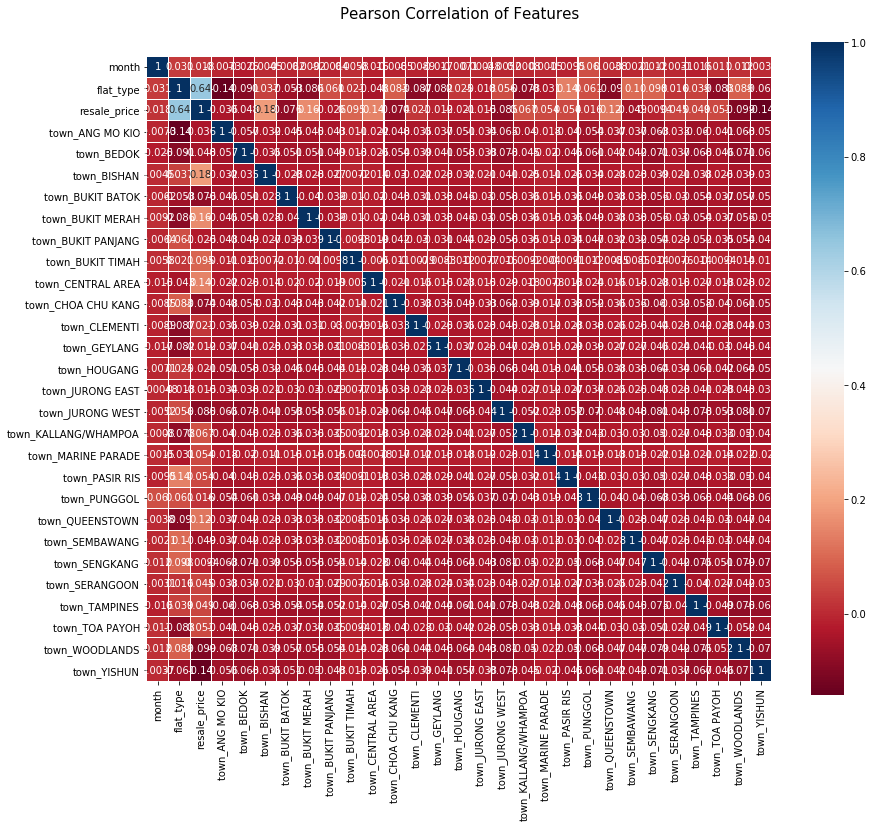

In [12]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(HDB_Resale_2015_2018Dec.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
# find correlation of features with output
results = HDB_Resale_2015_2018Dec.corr()
#results.sort_values?
results['resale_price'].sort_values(ascending=False)
# negative values do not mean not correlated. 



resale_price            1.000000
flat_type               0.644180
town_BISHAN             0.184396
town_BUKIT MERAH        0.158731
town_CENTRAL AREA       0.144877
town_QUEENSTOWN         0.124476
town_BUKIT TIMAH        0.095431
town_KALLANG/WHAMPOA    0.066809
town_MARINE PARADE      0.054262
town_PASIR RIS          0.054063
town_TOA PAYOH          0.050891
town_TAMPINES           0.048594
town_SERANGOON          0.045417
town_CLEMENTI           0.020939
month                   0.017841
town_PUNGGOL            0.016135
town_SENGKANG          -0.009449
town_GEYLANG           -0.012102
town_JURONG EAST       -0.015995
town_HOUGANG           -0.021164
town_BUKIT PANJANG     -0.026005
town_ANG MO KIO        -0.036025
town_BEDOK             -0.047914
town_SEMBAWANG         -0.048730
town_CHOA CHU KANG     -0.073562
town_BUKIT BATOK       -0.076492
town_JURONG WEST       -0.084855
town_WOODLANDS         -0.099048
town_YISHUN            -0.141765
Name: resale_price, dtype: float64

In [14]:
HDB_Resale_2015_2018Dec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79100 entries, 0 to 79099
Data columns (total 29 columns):
month                   79100 non-null int32
flat_type               79100 non-null int64
resale_price            79100 non-null float64
town_ANG MO KIO         79100 non-null uint8
town_BEDOK              79100 non-null uint8
town_BISHAN             79100 non-null uint8
town_BUKIT BATOK        79100 non-null uint8
town_BUKIT MERAH        79100 non-null uint8
town_BUKIT PANJANG      79100 non-null uint8
town_BUKIT TIMAH        79100 non-null uint8
town_CENTRAL AREA       79100 non-null uint8
town_CHOA CHU KANG      79100 non-null uint8
town_CLEMENTI           79100 non-null uint8
town_GEYLANG            79100 non-null uint8
town_HOUGANG            79100 non-null uint8
town_JURONG EAST        79100 non-null uint8
town_JURONG WEST        79100 non-null uint8
town_KALLANG/WHAMPOA    79100 non-null uint8
town_MARINE PARADE      79100 non-null uint8
town_PASIR RIS          79100 non-

In [15]:
y = HDB_Resale_2015_2018Dec['resale_price']
y.head(5)

0    255000.0
1    275000.0
2    285000.0
3    290000.0
4    290000.0
Name: resale_price, dtype: float64

In [26]:
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

onehotencoder = OneHotEncoder(categorical_features = [3])

In [37]:
# Split data intro train and validation sets
X_train, X_test, y_train, y_test = \
    train_test_split(HDB_Resale_2015_2018Dec.copy(), HDB_Resale_2015_2018Dec['resale_price'].copy(), test_size=0.3, random_state=42)
print('Shapes')
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

Shapes
X_train: (55370, 29)
X_test: (23730, 29)
y_train: (55370,)
y_test: (23730,)


In [38]:
X_train = onehotencoder.fit_transform(X_train).toarray()
X_test = onehotencoder.fit_transform(X_test).toarray()

In [39]:
X_train

array([[1.000e+00, 0.000e+00, 2.017e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.016e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.018e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 0.000e+00, 2.018e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [40]:
X_test

array([[1.000e+00, 0.000e+00, 2.018e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.015e+03, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.017e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 0.000e+00, 2.018e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 0.000e+00, 2.015e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [42]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,y_train)
y_pred = regressor.predict(X_test)
y_pred

array([555000., 465000., 340000., ..., 500888., 508000., 268000.])

D:\Users\Ocean\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [43]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

1.0

Liner Regression RMSE: 0.0000
